In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import numpy

import numpy as np
import pandas as pd
import os
import pickle as pl
import h5py
from scipy.constants import c, pi

In [3]:
from functions import *

In [4]:


import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm


In [5]:
from numpy.fft import fftshift
from fft_module import *
import scipy

In [6]:
def fft(x):
    return scipy.fft(x.T).T

In [7]:
class Conversion_efficiency(object):

    def __init__(self, freq_band, possition, filename=None, filepath='',filename2 = 'CE',filepath2 = 'output_final/'):
        self.variables = ('P_p', 'P_s', 'f_p', 'f_s','l_p','l_s,' 'P_out', 'P_bef','CE','rounds')
        
        self.spec, self.fv, self.t, self.P0_p, self.P0_s,self.f_p, self.f_s, self.P_bef,self.ro,U_large,tt =\
            self.load_spectrum('0',filename, filepath)
        self.P_max = np.max(w2dbm(self.spec))
        
        self.spec, self.fv, self.t, self.P0_p, self.P0_s,self.f_p, self.f_s, self.P_bef,self.ro,U_large,tt =\
            self.load_spectrum(possition,filename, filepath)
        self.tt = tt
       
        self.freq_band = freq_band

        self.U_large = np.asanyarray(U_large)#[:,:,0]
        self.nt = np.shape(self.spec)[0]
        if possition == '2':
            print('finding signal')
            fv_id = self.pos_of_signal()
        else:
            print('finding idler')
            fv_id = self.pos_of_idler()
        
        #self.fv_d = fv_id
        #print(np.shape(self.U_large))
        #sys.exit()
        self.P_in = self.P0_p + self.P0_s
        lami = 1e-3*c/self.fv[fv_id]
        self.lami = lami
        self.lamp = 1e-3*c/self.f_p
        self.l_s = 1e-3*c/self.f_s
        self.U_large_norm =  w2dbm(np.abs(self.U_large)**2) - self.P_max 
        P_out_vec = []
        P_out_vec_casc = []
        self.fv_id = fv_id
        start, end= self.fv[fv_id] - freq_band, self.fv[fv_id] + freq_band
        fv_id_c = self.pos_of_cascade()
        start_c, end_c = self.fv[fv_id_c] - freq_band, self.fv[fv_id_c] + freq_band
        for i in U_large:
            self.spec = np.abs(i)**2
            P_out_vec.append(self.calc_P_out(start,end))
            P_out_vec_casc.append(self.calc_P_out(start_c,end_c))
        self.P_out_vec_casc = np.asanyarray(P_out_vec_casc)
        self.P_out_vec = np.asanyarray(P_out_vec)
        self.P_out = np.mean(P_out_vec)
        self.CE = self.calc_CE()
        
        self.std = { i : None for i in ('P_p', 'P_s', 'f_p', 'f_s','l_p','l_s,' 'P_out', 'P_bef','CE','rounds')}
        self.std['P_out'] = np.std(P_out_vec)
        self.std['CE'] = self.std['P_out']*self.CE/self.P_in
        
        self.read_write_CE_table(filename2,var = None, P_p = self.P0_p, P_s = self.P0_s, f_p = self.f_p,
                                         f_s = self.f_s,P_out = self.P_out,P_bef = self.P_bef, CE = self.CE, var2 = 'CE',std = self.std,file_path=filepath2)
        self.spec = np.mean(np.abs(U_large[0:][:])**2, axis = 0)

        self.spec_s = w2dbm(self.spec)-self.P_max 
        return None

    
    def pos_of_idler(self):
        U_sum = np.sum(np.abs(self.U_large)**2, axis = 0)
        plom = self.nt//2+50
        fv_id = np.where(U_sum[plom:] == np.max(U_sum[plom:]))[0][0]
        fv_id += plom
        return fv_id
    
    def pos_of_signal(self):
        U_sum = np.sum(np.abs(self.U_large)**2, axis = 0)
        plom = self.nt//2 -50
        fv_id = np.where(U_sum[:plom] == np.max(U_sum[:plom]))[0][0]
        return fv_id
    
    
    def pos_of_cascade(self):
        sig_id = self.pos_of_signal() - 50
        U_sum = np.sum(np.abs(self.U_large)**2, axis = 0)
        plom = sig_id
        fv_id = np.where(U_sum[:plom] == np.max(U_sum[:plom]))[0][0]
        return fv_id
    
    def load_spectrum(self, possition,filename='data_large', filepath=''):
        with h5py.File(filepath+filename+'.hdf5','r') as f: 
            l = f.get(possition)
            U_large = ()
            integers_list = [int(i) for i in l.keys()]
            integers_list.sort()
            integers_generator = (str(n) for n in integers_list)
            for i in integers_generator:
                steady_state = i
                layers = possition + '/' + steady_state
                D = read_variables(filename,layers, filepath)
                U = D['U']
                U_large += (U,)

            fv = D['fv']
            ro = D['ro']

            Uabs = w2dbm(np.abs(U)**2)
            P0_s = D['P0_s']
            P0_p = D['P0_p']
            t = D['t']
            f_p = D['f_p']
            f_s = D['f_s']
            layers = '1/0'
            
            D = read_variables(filename,layers, filepath)
            Uabss =np.abs(D['U'])**2
            fvs = D['fv']
            tt = D['t']

            P_bef = simps(Uabss,fvs)
            P_bef /= 2*np.max(tt)
        return dbm2w(Uabs), fv,t, P0_p, P0_s, f_p, f_s,P_bef, ro, U_large,t



    def calc_P_out(self,start,end):
        i = np.where(
            np.abs(self.fv - start) == np.min(np.abs(self.fv - start)))[0][0]
        j = np.where(
            np.abs(self.fv - end) == np.min(np.abs(self.fv - end)))[0][0]

        E_out = simps(self.spec[i:j], self.fv[i:j])
        P_out = E_out/(2*np.max(self.tt))
        return P_out   


    def calc_CE(self):
        CE = 100*self.P_out/self.P_in
        return CE


    def read_write_CE_table(self,filename,var = None, P_p = None, P_s = None, f_p = None, f_s = None,P_out = None, P_bef = None,CE = None, var2 = 'CE',std = None,file_path=''):
        
        """ Given values of the parameters this function uses pandas to open an
            hdf5 file and append to the dataframe there. It also returns the full data
            for post-processing. 
            
            It returns a tuple of 2 numpy arrays the first with the variable var and the second with
            the conversion efficiencty (as default). If no input is given( default then it just reads the )
        """
        try:
            l_s = 1e-3*c/f_s
        except TypeError:
            l_s = None
            pass
        try:
            l_p = 1e-3*c/f_p
        except TypeError:
            l_p = None
            pass
        A = np.array([P_p, P_s, f_p, f_s,l_s,l_p, P_out, P_bef, CE]).T
        a = pd.DataFrame(A, index = ['P_p', 'P_s','f_p', 'f_s','l_s','l_p', 'P_out','P_bef', 'CE']).T
        try:
            ab = pd.read_hdf(file_path+filename+'.hdf5')
            if not(A.any() == None):
                ab = ab.append(a, ignore_index=True)
        except IOError:
            if not(A.any() == None):
                ab = a
            else: 
                sys.exit("There is no data in file or given")
            pass
        store = ab.to_hdf(file_path+filename+'.hdf5',key='a')
        b = pd.DataFrame.from_dict([std])
        try:
            ba = pd.read_hdf(file_path+filename+'_std.hdf5', key = 'b')
            if not(A.any() == None):
                ba = ba.append(b, ignore_index=True)
        except IOError:
            if not(A.any() == None):
                ba = b
            else: 
                sys.exit("There is no data in file or given")
            pass
        store2 = ba.to_hdf(file_path+filename+'_std.hdf5', key = 'b')

        if var is None:
            return None
        else:
            return ab[var].as_matrix(),ab[var2].as_matrix(),ba


    def plot_CE(self,var,var2 = 'CE',filename = 'CE', filepath='output_final/', filesave= None):
        var_val, CE,std = self.read_write_CE_table(filename,var,var2 = var2,file_path=filepath)
        std = std[var2].as_matrix()
        fig = plt.figure(figsize=(20.0, 10.0))
        plt.errorbar(var_val, CE, yerr=std, capsize= 10)
        plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
        plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
        plt.xlabel(var)
        plt.ylabel(var2)
        plt.savefig(filesave+'.png',bbox_inches = 'tight')
        data = (var_val, CE)
        pl.dump((fig,data),open(str(filesave)+'.pickle','wb'))
           
        #plt.close(fig)
        return None
    def P_out_round(self,filesave):
        """Plots the output average power with respect to round trip number"""
        self.l_p = 1e-3*c/self.f_p
        fig = plt.figure(figsize=(20,10))
        plt.plot(range(len(self.P_out_vec)), self.P_out_vec)
        plt.xlabel('Rounds')
        plt.ylabel('Output Power')
        plt.title(f"$P_p=$ {float(CE.P0_p):.{2}} W, $P_s=$ {float(CE.P0_s*1e3):.{2}} mW, $\lambda_p=$ {float(CE.l_p):.{6}} nm,  $\lambda_s=$ {float(CE.l_s):.{6}} nm, maximum output at: {float(CE.lami):.{6}} nm")
        plt.savefig('power_per_round'+filesave+'.png')

        data = (range(len(self.P_out_vec)), self.P_out_vec)
        _data ={'pump_power':self.P0_p, 'pump_wavelength': self.l_p, 'out_wave': self.lami}
        pl.dump(fig,open('power_per_round'+filesave+'.pickle','wb'))
        plt.close()
    
    def P_out_round_casc(self,filesave):
        """Plots the output average power with respect to round trip number"""
        self.l_p = 1e-3*c/self.f_p
        fig = plt.figure(figsize=(20,10))
        plt.plot(range(len(self.P_out_vec)), self.P_out_vec_casc)
        plt.xlabel('Rounds')
        plt.ylabel('Output Power')
        plt.title(f"$P_p=$ {float(CE.P0_p):.{2}} W, $P_s=$ {float(CE.P0_s*1e3):.{2}} mW, $\lambda_p=$ {float(CE.l_p):.{6}} nm,  $\lambda_s=$ {float(CE.l_s):.{6}} nm, maximum output at: {float(CE.lami):.{6}} nm")
        plt.savefig('power_per_round_casc'+filesave+'.png')
        data = (range(len(self.P_out_vec)), self.P_out_vec)
        _data ={'pump_power':self.P0_p, 'pump_wavelength': self.l_p, 'out_wave': self.lami}
        pl.dump(fig,open('power_per_round_casc'+filesave+'.pickle','wb'))
        plt.close()

In [8]:
def contor_plot(CE,fmin = None,fmax = None,  rounds = None,filename = None):
    if not(fmin):
        fmin = CE.fv[CE.fv_id] - CE.freq_band
    if not(fmax):
        fmax = CE.fv[CE.fv_id] + CE.freq_band
    print(fmin,fmax)
    i = np.where(np.abs(CE.fv - fmin) == np.min(np.abs(CE.fv - fmin)))[0][0]
    j = np.where(np.abs(CE.fv - fmax) == np.min(np.abs(CE.fv - fmax)))[0][0]
    


    if rounds is None:
        rounds = np.shape(CE.U_large_norm)[0]
   
    CE.ro = range(rounds)
    x,y = np.meshgrid(CE.ro[:rounds], CE.fv[i:j])
    z = CE.U_large_norm[:rounds,i:j].T
    #print(np.shape(x), np.shape(z))
    low_values_indices = z < -60  # Where values are low
    z[low_values_indices] = -60  # All low values set to 0
    fig = plt.figure(figsize=(20,10))
    plt.contourf(x,y, z,np.arange(-60,np.max(CE.U_large_norm),1), extend = 'min',cmap=plt.cm.jet)
    plt.xlabel(r'$rounds$')
    plt.ylim(fmin,fmax)
    #plt.xlim(0,200)
    plt.ylabel(r'$f(THz)$')
    plt.colorbar()
    l_p = 1e-3*c/CE.f_p
    plt.title(f"$P_p=$ {float(CE.P0_p):.{2}} W, $P_s=$ {float(CE.P0_s*1e3):.{2}} mW, $\lambda_p=$ {float(CE.l_p):.{6}} nm,  $\lambda_s=$ {float(CE.l_s):.{6}} nm, maximum output at: {float(CE.lami):.{6}} nm")
    data = (CE.ro, CE.fv, z )
    _data ={'pump_power':CE.P0_p, 'pump_wavelength': l_p, 'out_wave': CE.lami}
    if filename is not None:
        plt.savefig(str(filename), bbox_inches = 'tight')
        pl.dump((fig,data,_data),open(str(filename)+'.pickle','wb'))
        plt.close('all')
    else:
        plt.show()
    return None

In [9]:
which = 'output_dump_pump_wavelengths/7w'
which = 'output_dump_pump_wavelengths/wrong'
which = 'output_dump_pump_wavelengths'
#which = 'output_dump_pump_wavelengths/2_rounds'
#which ='output_dump_pump_powers/ram0ss0'
#which = 'output_dump/'#_pump_powers'
which_l = 'output_dump/output'
#which_l = 'output'

In [57]:
def final_1D_spec(ii,specs):
    filename = 'spectrum_fopo_final'
    fig = plt.figure(figsize=(20,10))
    #fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()

    ax1.plot(specs.fv, specs.spec_s, label = r'$\lambda_p$='+str(specs.l_p)+r', $\lambda_s $='+str(specs.l_s))

    ax1.set_xlabel(r'$f (THz)$')
    ax1.set_ylabel(r'spec (dB)')
    #ax1.set_xticks(np.arange(min(specs.fv), max(specs.fv)+1, 10))
    #ax1.set_ylim(260,320)
    #print(round(min(specs.fv)),round(max(specs.fv)))
    #sys.exit()
    ax1.set_xticks(np.arange(round(min(specs.fv)),round(max(specs.fv)),10))
    new_tick_locations = ax1.get_xticks()

    def tick_function(X):
        l = 1e-3*c/X
        return ["%.2f" % z for z in l]
    
    ax1.set_ylim(-100,0)
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(tick_function(new_tick_locations))
    ax2.set_xlabel(r"$\lambda (nm)$")
    #plt.ylim(260,320)
    ax1.legend()
    plt.savefig(filename+str(ii)+'.png', bbox_inches = 'tight')
    #plt.show()

    pl.dump(fig,open(filename+str(ii)+'.pickle','wb'))
    #plt.close('all')
    #sys.exit()
    return None

In [58]:
%matplotlib inline

finding signal


/home/john/miniconda3/lib/python3.6/site-packages/pandas/core/generic.py:1138: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['P_bef', 'P_p', 'P_s', 'f_p', 'f_s', 'l_p', 'l_s,P_out', 'rounds']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


254.288375098 324.741795676
1051.5 1051.5
finding signal
252.508412084 327.030638865
1051.5 1051.5
finding signal
250.734987043 329.311074917
1051.5 1051.5
finding signal
248.968064018 331.583150066
1051.5 1051.5
finding signal
247.207607318 333.84691021
1051.5 1051.5
finding signal
245.453581509 336.102400911
1051.5 1051.5
finding signal
243.705951419 338.349667398
1051.5 1051.5
finding signal
241.96468213 340.588754571
1051.5 1051.5
finding signal
240.229738978 342.819707004
1051.5 1051.5
finding signal
238.501087551 345.042568947
1051.5 1051.5
finding signal
236.778693686 347.257384332
1051.5 1051.5
finding signal
235.062523466 349.46419677
1051.5 1051.5
finding signal
233.35254322 351.663049561
1051.5 1051.5
finding signal
231.648719519 353.853985689
1051.5 1051.5
finding signal
229.951019173 356.037047833
1051.5 1051.5
finding signal
228.259409232 358.212278364
1051.5 1051.5
P_out
CE


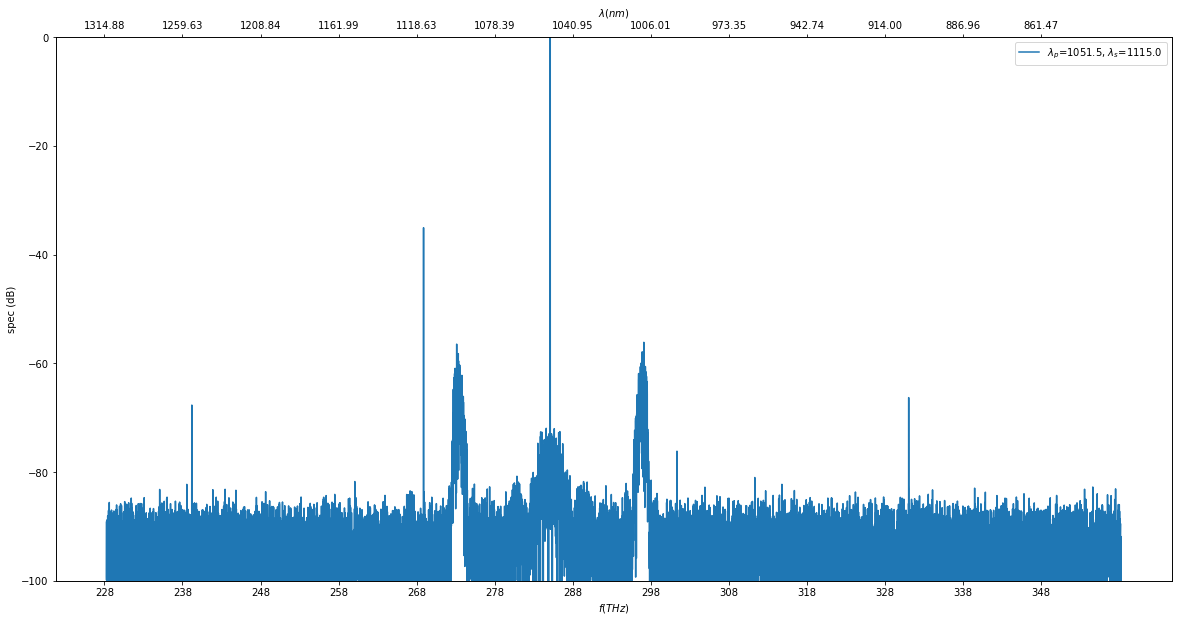

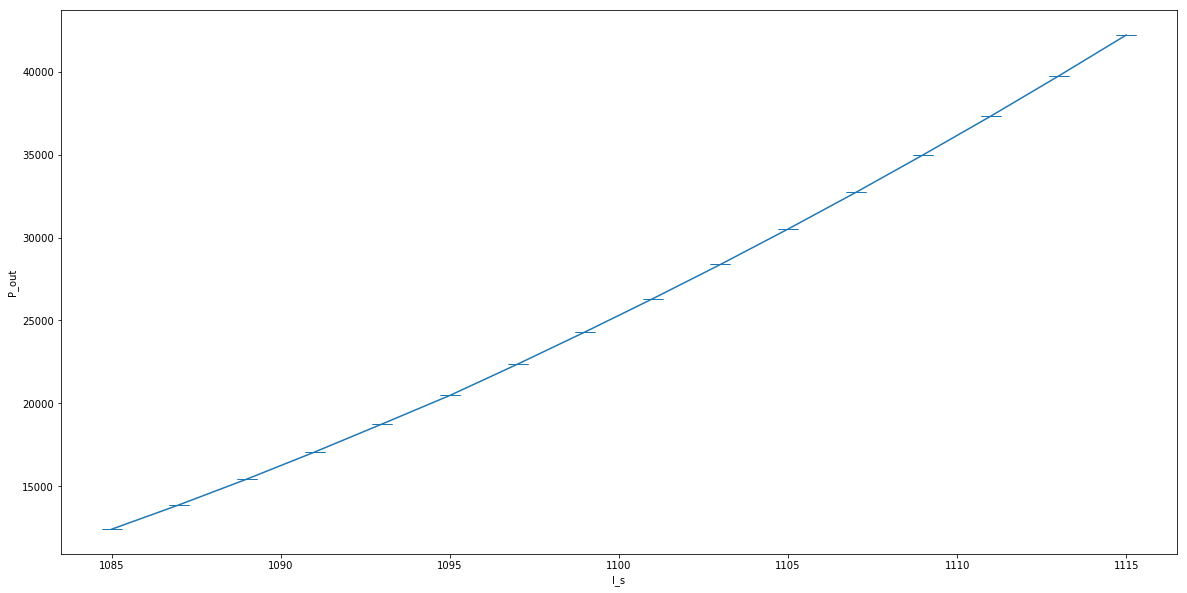

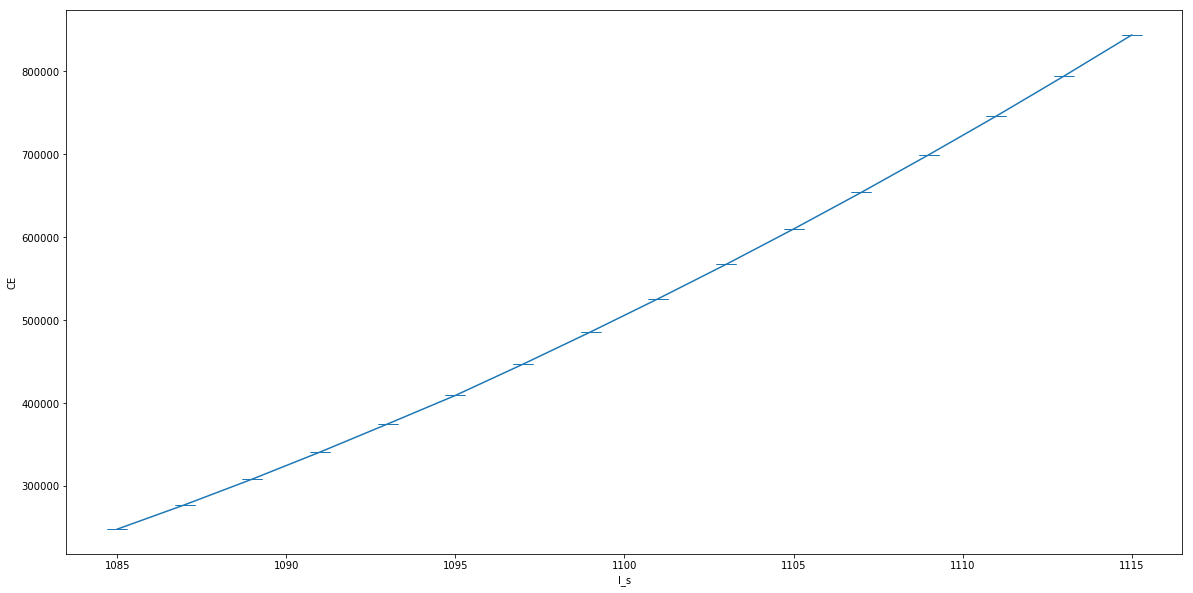

In [59]:
for ii in range(1):
    ii = str(ii)
    which = which_l+ ii
    os.system('rm output_final/CE.hdf5 output_final/CE_std.hdf5')
    lami_vec = []
    lamp_vec = []
    specs_large = []
    for i in range(16):
        CE = Conversion_efficiency(1,possition = '2', filename = 'data_large',filepath = which+'/output'+str(i)+'/data/')
        fmin,fmax,rounds  = 310,330,None#np.min(CE.fv),np.max(CE.fv),None
        fmin,fmax,rounds = None, None, None
        fmin,fmax,rounds = np.min(CE.fv),np.max(CE.fv), None
        
        #(np.min(CE.fv)+np.max(CE.fv))/2 +10
        lami_vec.append(CE.lami)
        specs_large.append(CE)
        lamp_vec.append(CE.lamp)
        #contor_plot(CE,fmin,fmax,rounds,filename= str(ii)+'_'+str(i))
        CE.P_out_round(filesave = str(ii)+'_'+str(i))
        CE.P_out_round_casc(filesave = str(ii)+'_'+str(i))
        #rounds = 16000
        contor_plot(CE,fmin,fmax,rounds,filename= str(ii)+'_'+str(i))
        final_1D_spec(i,CE)
        print(1e-3*c/CE.f_p, CE.lami)
    var1, var2 = 'P_bef', 'P_out'
    os.system('mkdir output_final/'+ii)
    for var1,var2 in (('l_s', 'P_out'), ('l_s', 'CE')):
        print(var2)
        CE.plot_CE(var1, var2,filesave = 'output_final/'+ii+'/'+var2+str(ii))  

    os.system('mv *png output_final/'+ii)
    os.system('mv *pickle output_final/'+ii)

In [56]:
round(10.34950,1)

10.3

In [14]:
import os
ii = str(0)
os.system('mv *png output_final/'+ii)
os.system('mv *pickle output_final/'+ii)

256

In [15]:
np.max(CE.U_large_norm[:rounds,:].T)

-0.00047682717432451227

In [16]:
U_sum = np.sum(np.abs(CE.U_large)**2, axis = 0)
plom = CE.nt//2 -50
fv_id = np.where(U_sum[:plom] == np.max(U_sum[:plom]))[0][0]
#fv_id += plom+50

In [17]:
CE.fv[fv_id]

285.10932762719921

/home/john/miniconda3/lib/python3.6/site-packages/pandas/core/generic.py:1138: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['P_bef', 'P_p', 'P_s', 'f_p', 'f_s', 'l_p', 'l_s,P_out', 'rounds']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


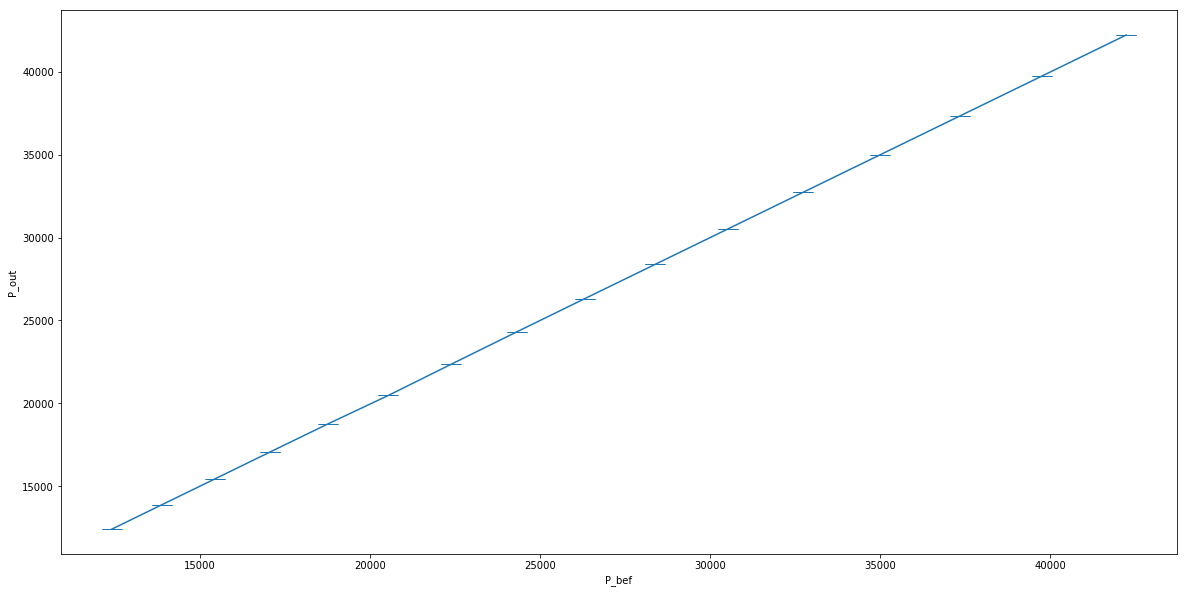

In [18]:
%matplotlib inline
CE.plot_CE('P_bef',var2 = 'P_out',filename = 'CE', filepath='output_final/', filesave= 'power')

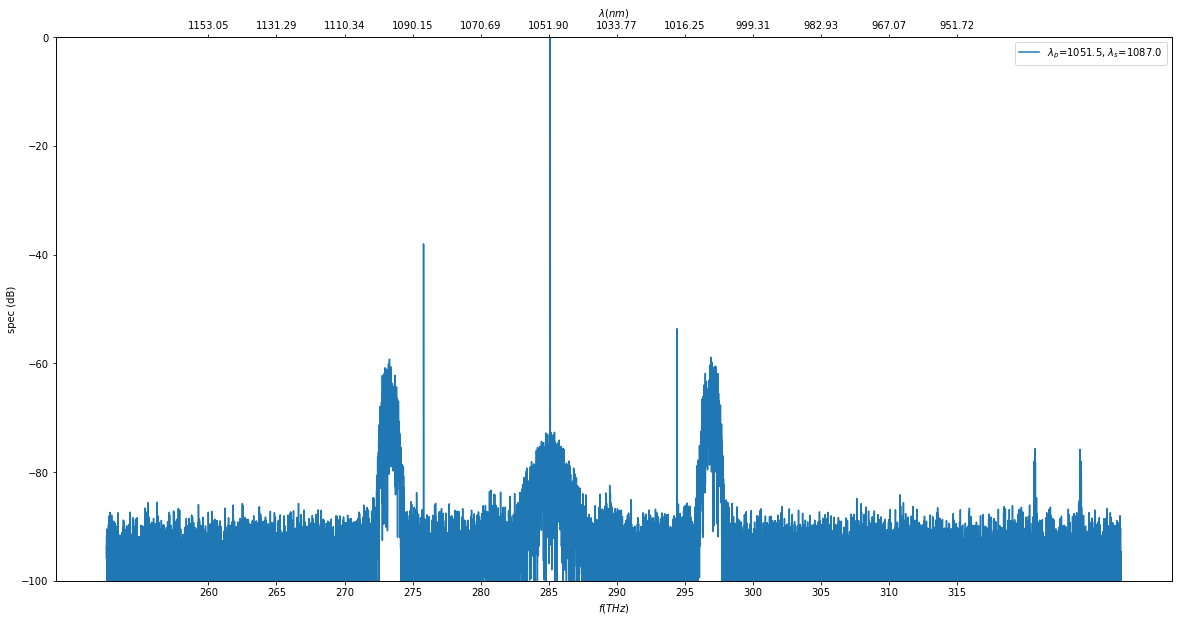

In [19]:
final_1D_spec(ii,specs_large[1])

In [20]:


for i in specs_large[:1]:
    
    os.system('cp *png output_final/')
    os.system('cp *pickle output_final/')
plt.show()


In [21]:
a = [4,5,7,14,34,65]
b = [4,6,7,8,36,25]


In [22]:
inside_var = zip(a,b)

In [23]:
inside_var = zip(inside_var,a)

In [24]:
np.arange(1085, 1116, 2)[3:9]

array([1091, 1093, 1095, 1097, 1099, 1101])

In [25]:
np.arange(1091, 1101, 1)

array([1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100])

In [26]:
inside_var

In [27]:
D_ins = [{'index':i, inside_var_key: insvar} for i,insvar in enumerate(inside_var)]

NameError: name 'inside_var_key' is not defined

In [ ]:
np.arange(1060, 1071, 0.5)

In [ ]:
1e-3*c/273

In [ ]:
np.arange(1085, 1115, 1)

In [ ]:
20*4*2000/60/60/24

In [ ]:
len(np.arange(1085, 1115, 2))

In [ ]:
0.0164805445406172*2000
